Reference:

https://towardsdatascience.com/a-step-by-step-guide-to-calculating-autocorrelation-and-partial-autocorrelation-8c4342b784e8

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.tsatools import lagmat
from statsmodels.compat.numpy import lstsq

Check the current version of the statsmodels library:

In [2]:
import statsmodels
statsmodels.__version__

'0.13.2'

### Data

This dataset contains the number of air travel passengers per month from the start of 1949 to the end of 1960.

In [3]:
df_orig = pd.read_csv('data/AirPassengers.csv')
df_orig = df_orig.iloc[:50, :]

In [4]:
df_orig['Passengers'] = df_orig['Passengers'].astype(int)
df_orig['Month'] = pd.to_datetime(df_orig['Month'], infer_datetime_format=True)
df = df_orig.copy()
df = df.set_index(['Month'])

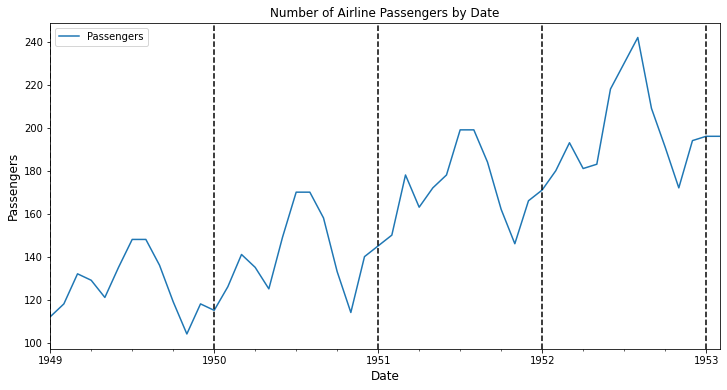

In [5]:
df_orig.plot(x='Month', y='Passengers', figsize=(12,6))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
for i in range(12):
    plt.axvline(x=f'{str(1949+i)}-01-01', color='black', linestyle='--')
plt.show()

/Users/javier.fernandez/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


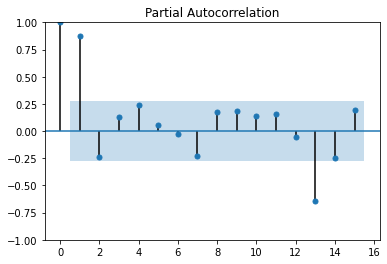

In [6]:
# Autocorrelation
_ = plot_pacf(df, lags=15)

In [7]:
N_LAGS = 15

### ACF

https://github.com/statsmodels/statsmodels/blob/35b803767bd7803ca5f9fc35d4546aa8cb7be844/statsmodels/tsa/stattools.py#L573

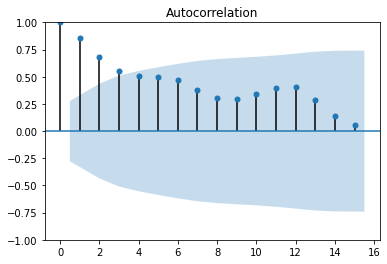

In [8]:
_ = plot_acf(df, lags=15)

In [9]:
def acovf(x):    
    x = df.iloc[:, 0].to_numpy()
    xo = x - x.mean()
    acov = np.correlate(xo, xo, "full")[len(x)-1:] / len(x)  # Cross correlation
    return acov[:N_LAGS+1].copy()


def acf_func(x):
    avf = acovf(x)
    acf = avf[: N_LAGS+1] / avf[0]
    return acf

In [10]:
acf_func(df)

array([1.        , 0.8558618 , 0.67726146, 0.54848013, 0.50404861,
       0.49448464, 0.4698961 , 0.380111  , 0.30766922, 0.29557531,
       0.33879597, 0.39564183, 0.40553831, 0.28227175, 0.13647793,
       0.05976272])

In [11]:
acf(df, bartlett_confint=False, nlags=N_LAGS, fft=False)

array([1.        , 0.8558618 , 0.67726146, 0.54848013, 0.50404861,
       0.49448464, 0.4698961 , 0.380111  , 0.30766922, 0.29557531,
       0.33879597, 0.39564183, 0.40553831, 0.28227175, 0.13647793,
       0.05976272])

**Replicating it the wrong way:**

In [12]:
y = df["Passengers"]
acf_df = pd.DataFrame()
for lag in range(N_LAGS+1):
    acf_df[f"y_lag_{lag}"] = y.shift(lag)
acf_df.head()

,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_lag_13,y_lag_14,y_lag_15
Month,,,,,,,,,,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
acf_df.corr()["y_lag_0"].values

array([1.        , 0.88659237, 0.72630556, 0.60437664, 0.56598516,
       0.57797509, 0.57920204, 0.53160189, 0.49098701, 0.5339155 ,
       0.65009588, 0.82749576, 0.94775058, 0.80359731, 0.56373428,
       0.43381299])

Something is off and the values do not match our benchmark. And what could be the reason for that? As is often the case, the devil is in the details. Let’s have a look at the autocorrelation formula.

There are a few things that call for our attention here:
- all the series in the formula are demeaned, that is, the average value has been subtracted from them. We have not done that explicitly, but that happens under the hood in the corr method.
- what is different from the general correlation formula — we are always subtracting the mean of the original series! Because we create the lags, the mean of the original series and the lagged ones will not be the same.
- in the denominator, we divide by the variance of the original series. In Pearson’s correlation coefficient, we would divide by the multiplication of the standard deviations of the two considered variables.

**Replicating it the right way**

In [14]:
acf_list = []
mu = y.mean() 
for lag in range(0, N_LAGS):
    acf_list.append(np.dot((y - mu).iloc[lag:], (y.shift(lag) - mu).iloc[lag:]) / sum((y - mu) ** 2))
np.array(acf_list)

array([1.        , 0.8558618 , 0.67726146, 0.54848013, 0.50404861,
       0.49448464, 0.4698961 , 0.380111  , 0.30766922, 0.29557531,
       0.33879597, 0.39564183, 0.40553831, 0.28227175, 0.13647793])

### PACF

https://github.com/statsmodels/statsmodels/blob/35b803767bd7803ca5f9fc35d4546aa8cb7be844/statsmodels/tsa/stattools.py#L573

/Users/javier.fernandez/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


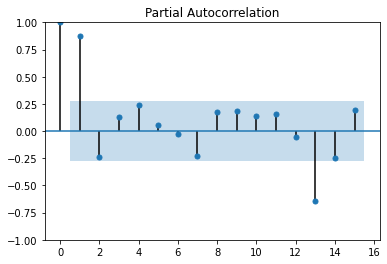

In [15]:
# Autocorrelation
_ = plot_pacf(df, lags=15)

In [16]:
def pacf_func(x):    
    pacf = np.empty(N_LAGS + 1)
    pacf[0] = 1.0

    xlags, x0 = lagmat(x, N_LAGS, original="sep")
    xlags = add_constant(xlags)

    for k in range(1, N_LAGS+1):
        # Return the least-squares solution to a linear matrix equation.
        params = lstsq(xlags[k:, :k+1], x0[k:], rcond=None)[0]
        pacf[k] = params[-1]

    return pacf

In [17]:
pacf_func(df)

array([ 1.        ,  0.87809448, -0.23904161,  0.1376273 ,  0.25350523,
        0.19051367, -0.06878642, -0.17063521,  0.2928152 ,  0.48558264,
        0.38139016,  0.63503532,  0.71567216, -0.37706004, -0.51590068,
        0.40299115])

In [18]:
pacf(df, method="ols", nlags=N_LAGS)

array([ 1.        ,  0.87809448, -0.23904161,  0.1376273 ,  0.25350523,
        0.19051367, -0.06878642, -0.17063521,  0.2928152 ,  0.48558264,
        0.38139016,  0.63503532,  0.71567216, -0.37706004, -0.51590068,
        0.40299115])

In [19]:
pacf_list = [1]
X = pd.DataFrame(lagmat(y, N_LAGS))
X.columns = [f"lag_{lag+1}" for lag in range(N_LAGS)]

for k in range(1, N_LAGS + 1):
    fitted_model = LinearRegression().fit(X.iloc[k:, :k], 
                                          y.iloc[k:])
    pacf_list.append(fitted_model.coef_[-1])

np.array(pacf_list)

array([ 1.        ,  0.87809448, -0.23904161,  0.1376273 ,  0.25350523,
        0.19051367, -0.06878642, -0.17063521,  0.2928152 ,  0.48558264,
        0.38139016,  0.63503532,  0.71567216, -0.37706004, -0.51590068,
        0.40299115])